<a href="https://colab.research.google.com/github/JohnnySunkel/BlueSky/blob/master/Reverse_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [0]:
model = ResNet50(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224, 224, 3))

In [0]:
def extract_features(img_path, model):
  input_shape = (224, 224, 3)
  img = image.load_img(img_path, 
                       target_size = (input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis = 0)
  preprocessed_img = preprocess_input(expanded_img_array)
  features = model.predict(preprocessed_img)
  flattened_features = features.flatten()
  normalized_features = flattened_features / norm(flattened_features)
  return normalized_features

In [0]:
extensions = ['.jpg', '.JPG', '.jpeg', ',JPEG', '.png', '.PNG']

In [0]:
def get_file_list(root_dir):
  file_list = []
  for root, directories, filenames in os.walk(root_dir):
    for filename in filenames:
      if any(ext in filename for ext in extensions):
        file_list.append(os.path.join(root, filename))
  return file_list

In [0]:
root_dir = 'drive/My Drive/101_ObjectCategories/'

In [0]:
filenames = sorted(get_file_list(root_dir))

In [0]:
pickle.dump(filenames, open('drive/My Drive/filenames-caltech101.pickle', 'wb'))

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size = (224, 224),
                                        batch_size = batch_size,
                                        class_mode = None,
                                        shuffle = False)

Found 8686 images belonging to 101 classes.


In [0]:
pickle.dump(generator.classes, open('drive/My Drive/class_ids-caltech101.pickle', 'wb'))

In [0]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
  feature_list.append(extract_features(filenames[i], model))

In [0]:
pickle.dump(feature_list, open('drive/My Drive/features-caltech101-resnet.pickle', 'wb'))

In [0]:
filenames = pickle.load(open('drive/My Drive/filenames-caltech101.pickle', 'rb'))

In [0]:
class_ids = pickle.load(open('drive/My Drive/class_ids-caltech101.pickle', 'rb'))

In [0]:
feature_list = pickle.load(open('drive/My Drive/features-caltech101-resnet.pickle', 'rb'))

In [0]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print('Number of images = ', num_images)
print('Number of features per image = ', num_features_per_image)

Number of images =  8686
Number of features per image =  100352


In [0]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors = 5,
                             algorithm = 'brute',
                             metric = 'euclidean').fit(feature_list)

In [0]:
random_index = 75
distances, indices = neighbors.kneighbors([feature_list[random_index]])

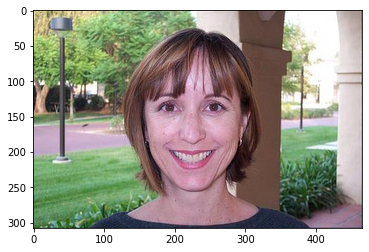

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filenames[random_index]), interpolation = 'lanczos')

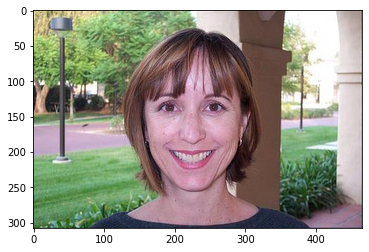

In [0]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]), interpolation = 'lanczos')

In [0]:
for i in range(5):
  print(distances[0][i])

1.0269917e-07
0.83171654
0.85249513
0.85427356
0.8590534


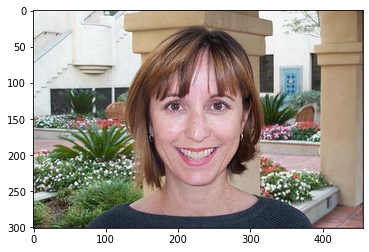

In [0]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation = 'lanczos')

In [0]:
# Helper function to get the classname
def classname(str):
  return str.split('/')[-2]

In [0]:
# Helper function to get the classname and filename
def classname_filename(str):
  return str.split('/')[-2] + '/' + str.split('/')[-1]

In [0]:
# Helper function to plot the nearest images given a query image
def plot_images(filenames, distances):
  images = []
  for filename in filenames:
    images.append(mpimg.imread(filename))
  plt.figure(figsize = (20, 10))
  columns = 4
  for i, image in enumerate(images):
    ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
    if i == 0:
      ax.set_title('Query Image\n' + classname_filename(filenames[i]))
    else:
      ax.set_title('Similar Image\n' + classname_filename(filenames[i]) +
                   '\nDistance: ' +
                   str(float('{0:.2f}'.format(distances[i]))))
    plt.imshow(image)

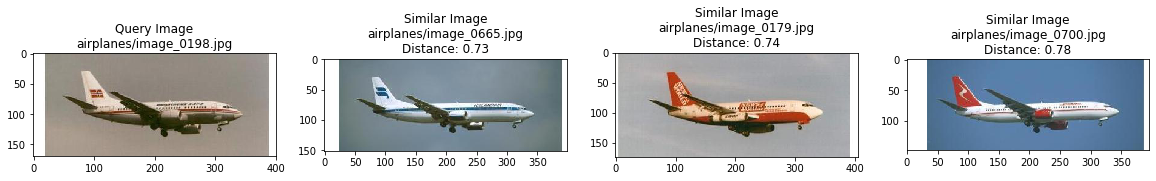

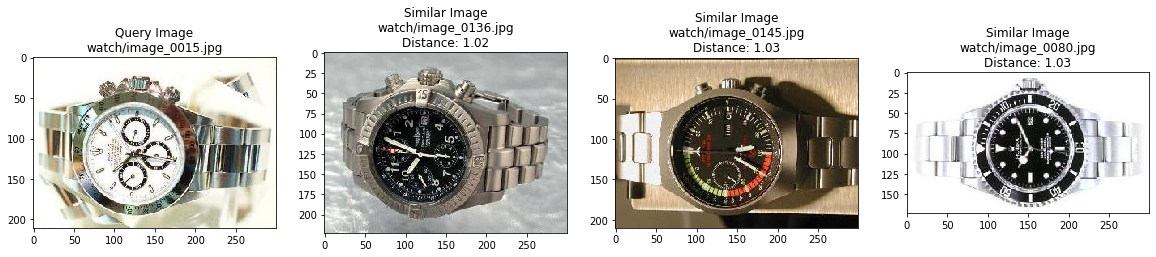

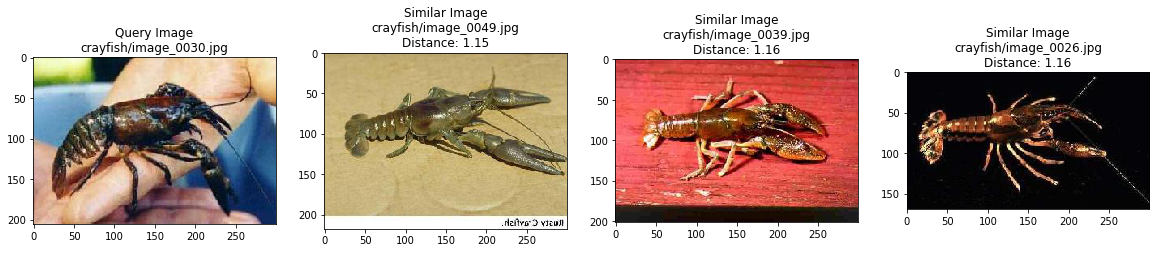

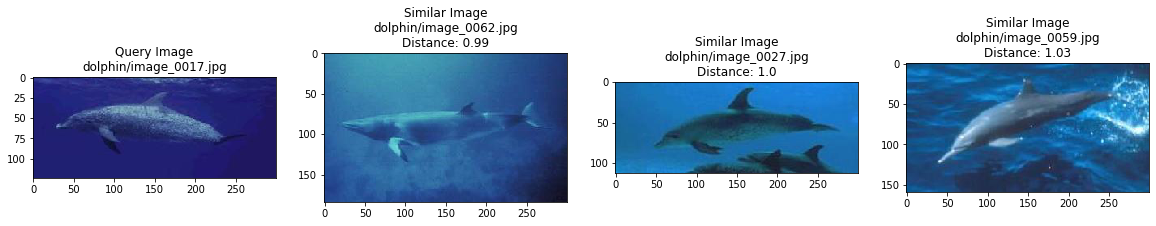

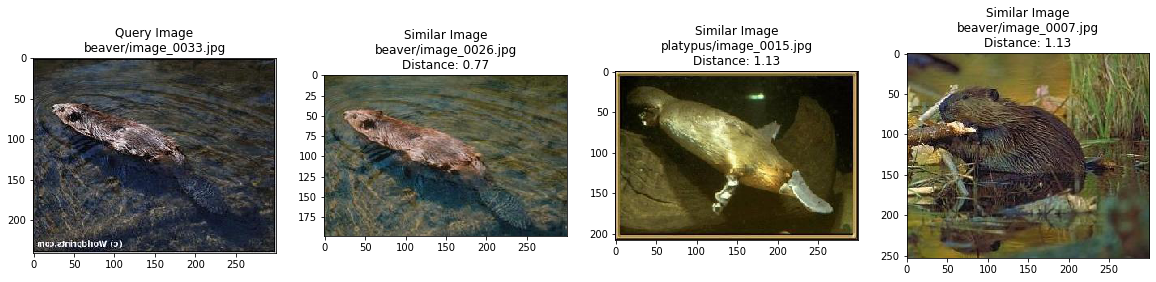

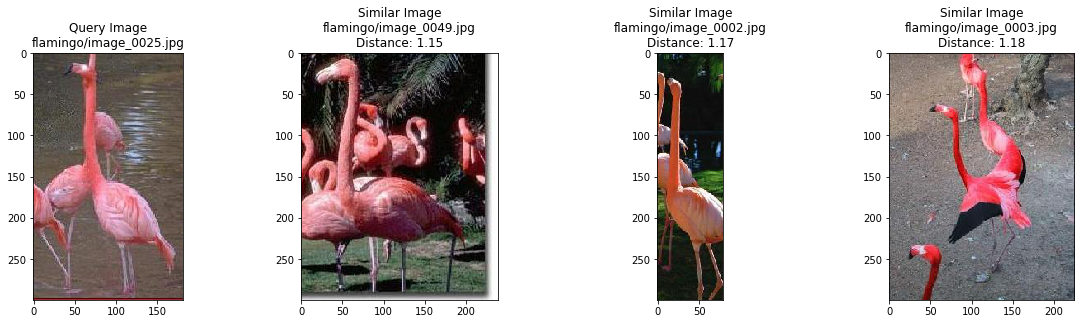

In [0]:
# Visualize the nearest neighbors of six random images 
import random
for i in range(6):
  random_image_index = random.randint(0, num_images)
  distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
  # Don't take the first closest image as it will be the same image
  similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1, 4)]
  plot_images(similar_image_paths, distances[0])


In [0]:
# Perform PCA over the features
from sklearn.decomposition import PCA

num_feature_dimensions = 100
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

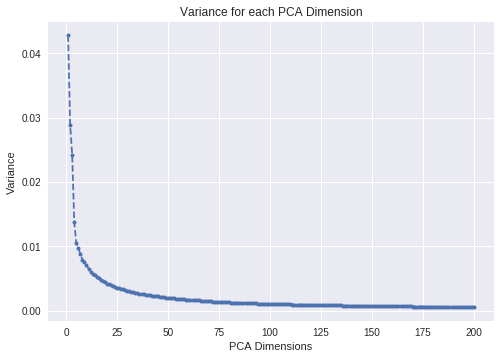

In [0]:
# Visualize the importance of the first 200 dimensions using PCA
import matplotlib

pca = PCA(200)
pca.fit(feature_list)
matplotlib.style.use('seaborn')
plt.plot(range(1 ,201), pca.explained_variance_ratio_, 'o--', markersize = 4)
plt.title('Variance for each PCA Dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

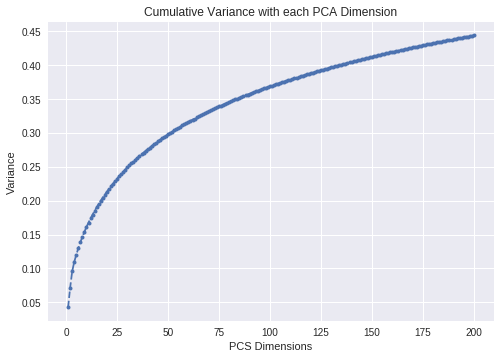

In [0]:
# Visualize the cumulative variance explained by PCA
plt.plot(range(1, 201), pca.explained_variance_ratio_.cumsum(), 'o--', markersize = 4)
plt.title('Cumulative Variance with each PCA Dimension')
plt.xlabel('PCS Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

In [0]:
# Helper function to calculate accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
  num_nearest_neighbors = 5
  correct_prediction = 0
  incorrect_prediction = 0
  neighbors = NearestNeighbors(n_neighbors = num_nearest_neighbors,
                               algorithm = 'brute',
                               metric = 'euclidean').fit(feature_list)
  start = time.time()
  for i in range(len(feature_list)):
    distances, indices = neighbors.kneighbors([feature_list[i]])
    for j in range(1, num_nearest_neighbors):
      if (classname(filenames[i]) == classname(filenames[indices[0][j]])):
        correct_prediction += 1
      else:
        incorrect_prediction += 1
  end = time.time()
  accuracy = round(100.0 * correct_prediction / (1.0 * correct_prediction + incorrect_prediction), 2), end - start
  return accuracy 

In [0]:
print('Accuracy on original feature list: ', calculate_accuracy(feature_list[:]))

In [17]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
  pca = PCA(n_components = dimensions)
  pca.fit(feature_list)
  feature_list_compressed = pca.transform(feature_list[:])
  accuracy, time_taken = calculate_accuracy(feature_list_compressed[:])
  pca_time.append(time_taken)
  pca_accuracy.append(accuracy)
  print('For PCA Dimensions = ', dimensions, ',\tAccuracy = ', accuracy, '%', ',\tTime = ', pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  21.23 % ,	Time =  4.790943384170532
For PCA Dimensions =  2 ,	Accuracy =  26.92 % ,	Time =  7.33387303352356
For PCA Dimensions =  3 ,	Accuracy =  32.98 % ,	Time =  7.269773006439209
For PCA Dimensions =  4 ,	Accuracy =  39.86 % ,	Time =  7.980680704116821
For PCA Dimensions =  5 ,	Accuracy =  45.87 % ,	Time =  8.158797025680542
For PCA Dimensions =  10 ,	Accuracy =  67.0 % ,	Time =  8.933335304260254
For PCA Dimensions =  20 ,	Accuracy =  80.09 % ,	Time =  9.985885381698608
For PCA Dimensions =  50 ,	Accuracy =  88.11 % ,	Time =  13.142292261123657
For PCA Dimensions =  75 ,	Accuracy =  89.84 % ,	Time =  16.109611988067627
For PCA Dimensions =  100 ,	Accuracy =  90.84 % ,	Time =  18.029914140701294
For PCA Dimensions =  150 ,	Accuracy =  91.83 % ,	Time =  23.14291501045227
For PCA Dimensions =  200 ,	Accuracy =  92.05 % ,	Time =  28.21256422996521


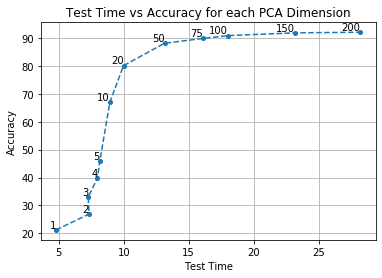

In [18]:
# Visualize the test time accuracy for each PCA dimension
plt.plot(pca_time, pca_accuracy, 'o--', markersize = 4)
for label, x, y, in zip(pca_dimensions, pca_time, pca_accuracy):
  plt.annotate(label, xy = (x, y), ha = 'right', va = 'bottom')
plt.title('Test Time vs Accuracy for each PCA Dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [0]:
# For speed and clarity, we'll analyze about the first half of the dataset
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]

In [0]:
# t-distributed Stochastic Neighbor Embeddings
from sklearn.manifold import TSNE

tsne_results =TSNE(n_components = 2,
                   verbose = 1,
                   metric = 'euclidean').fit_transform(selected_features) 


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.053s...
[t-SNE] Computed neighbors for 4000 samples in 2.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.147661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.158112
[t-SNE] KL divergence after 1000 iterations: 0.869009


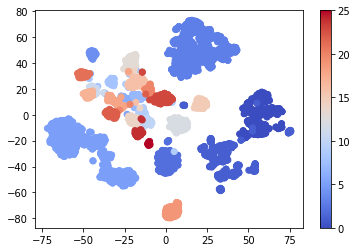

In [0]:
# Plot a scatterplot from the generated t-SNE results 
colormap = plt.cm.get_cmap('coolwarm')
scatterplot = plt.scatter(tsne_results[:, 0],
                          tsne_results[:, 1],
                          c = selected_class_ids, 
                          cmap = colormap)
plt.colorbar(scatterplot)
plt.show()

In [0]:
# Helper function to plot images in 2D for t-SNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from PIL import Image

def plot_images_in_2d(x, y, image_paths, axis = None, zoom = 1):
  if axis is None:
    axis = plt.gca()
  x, y = np.atleast_1d(x, y)
  for x0, y0, image_path in zip(x, y, image_paths):
    image = Image.open(image_path)
    image.thumbnail((100, 100), Image.ANTIALIAS)
    img = OffsetImage(image, zoom = zoom)
    anno_box = AnnotationBbox(img, (x0, y0),
                              xycoords = 'data',
                              frameon = False)
    axis.add_artist(anno_box)
  axis.update_datalim(np.column_stack([x, y]))
  axis.autoscale()

In [0]:
# Helper function to render a t-SNE plot
def show_tsne(x, y, selected_filenames):
  fig, axis = plt.subplots()
  fig.set_size_inches(22, 22, forward = True)
  plot_images_in_2d(x, y, selected_filenames, zoom = 0.3, axis = axis)
  plt.show()

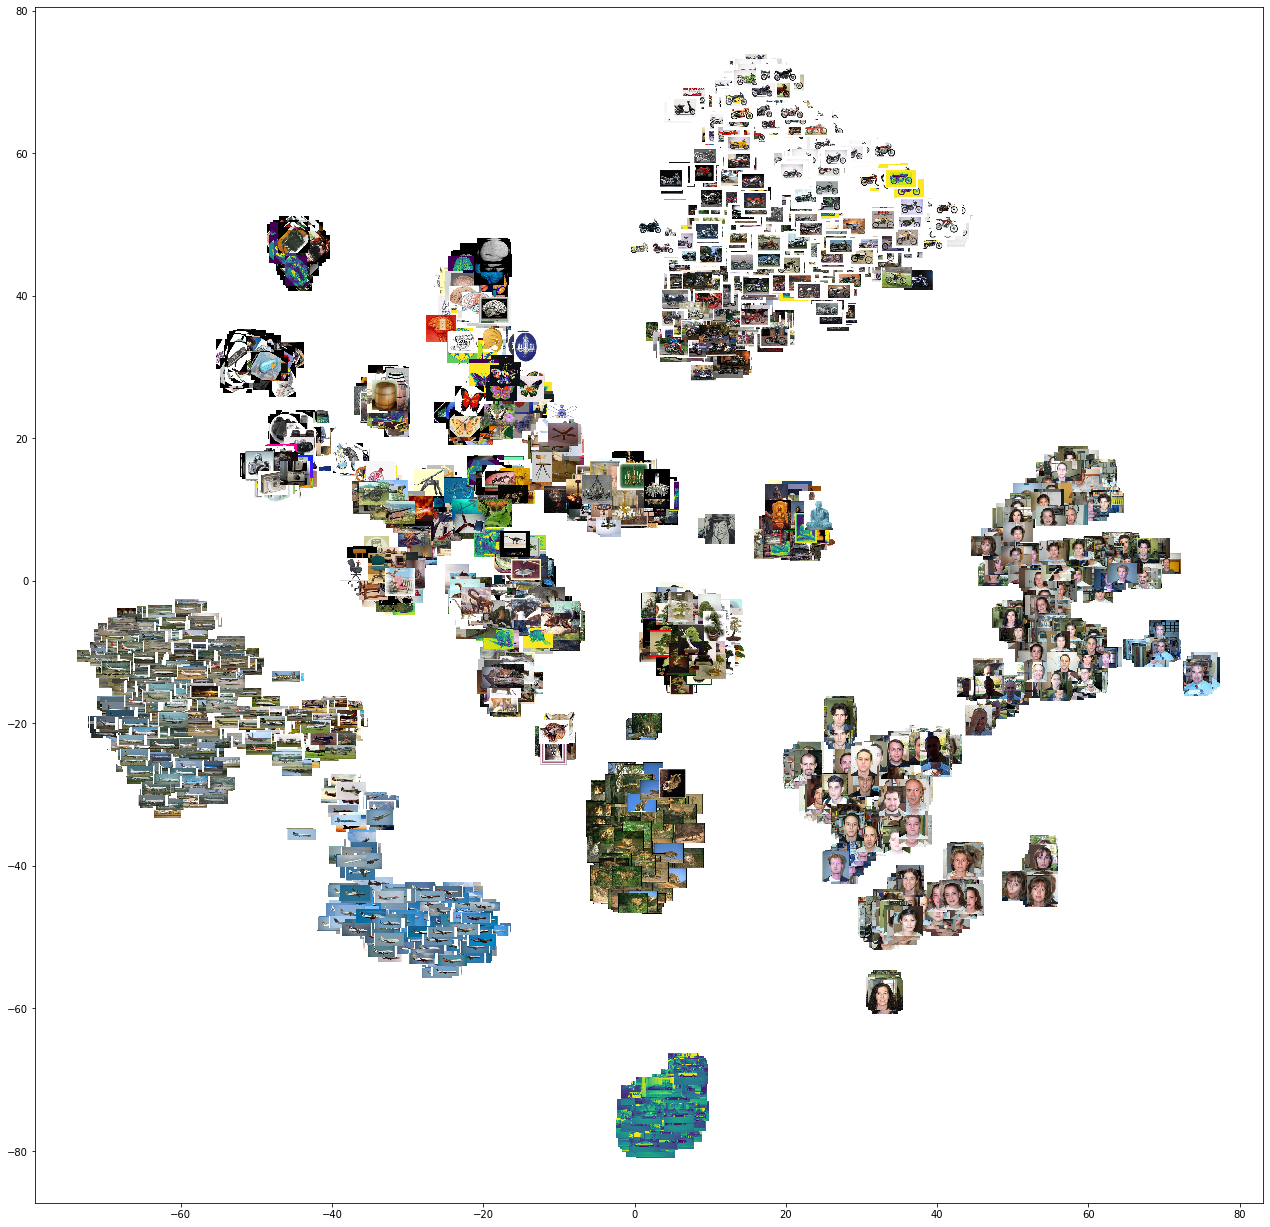

In [0]:
# Visualize the patterns in the images using t-SNE
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [0]:
# Helper function to space the images evenly
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
  S = 2000
  s = 100
  x = (x - min(x)) / (max(x) - min(x))
  y = (y - min(y)) / (max(y) - min(y))
  x_values = []
  y_values = []
  filename_plot = []
  x_y_dict = {}
  for i, image_path in enumerate(selected_filenames):
    a = np.ceil(x[i] * (S - s))
    b = np.ceil(y[i] * (S - s))
    a = int(a - np.mod(a, s))
    b = int(b - np.mod(b, s))
    if str(a) + '|' + str(b) in x_y_dict:
      continue
    x_y_dict[str(a) + '|' + str(b)] = 1
    x_values.append(a)
    y_values.append(b)
    filename_plot.append(image_path)
  fig, axis = plt.subplots()
  fig.set_size_inches(22, 22, forward = True)
  plot_images_in_2d(x_values, y_values, filename_plot, zoom = 0.58, axis = axis)
  plt.show()

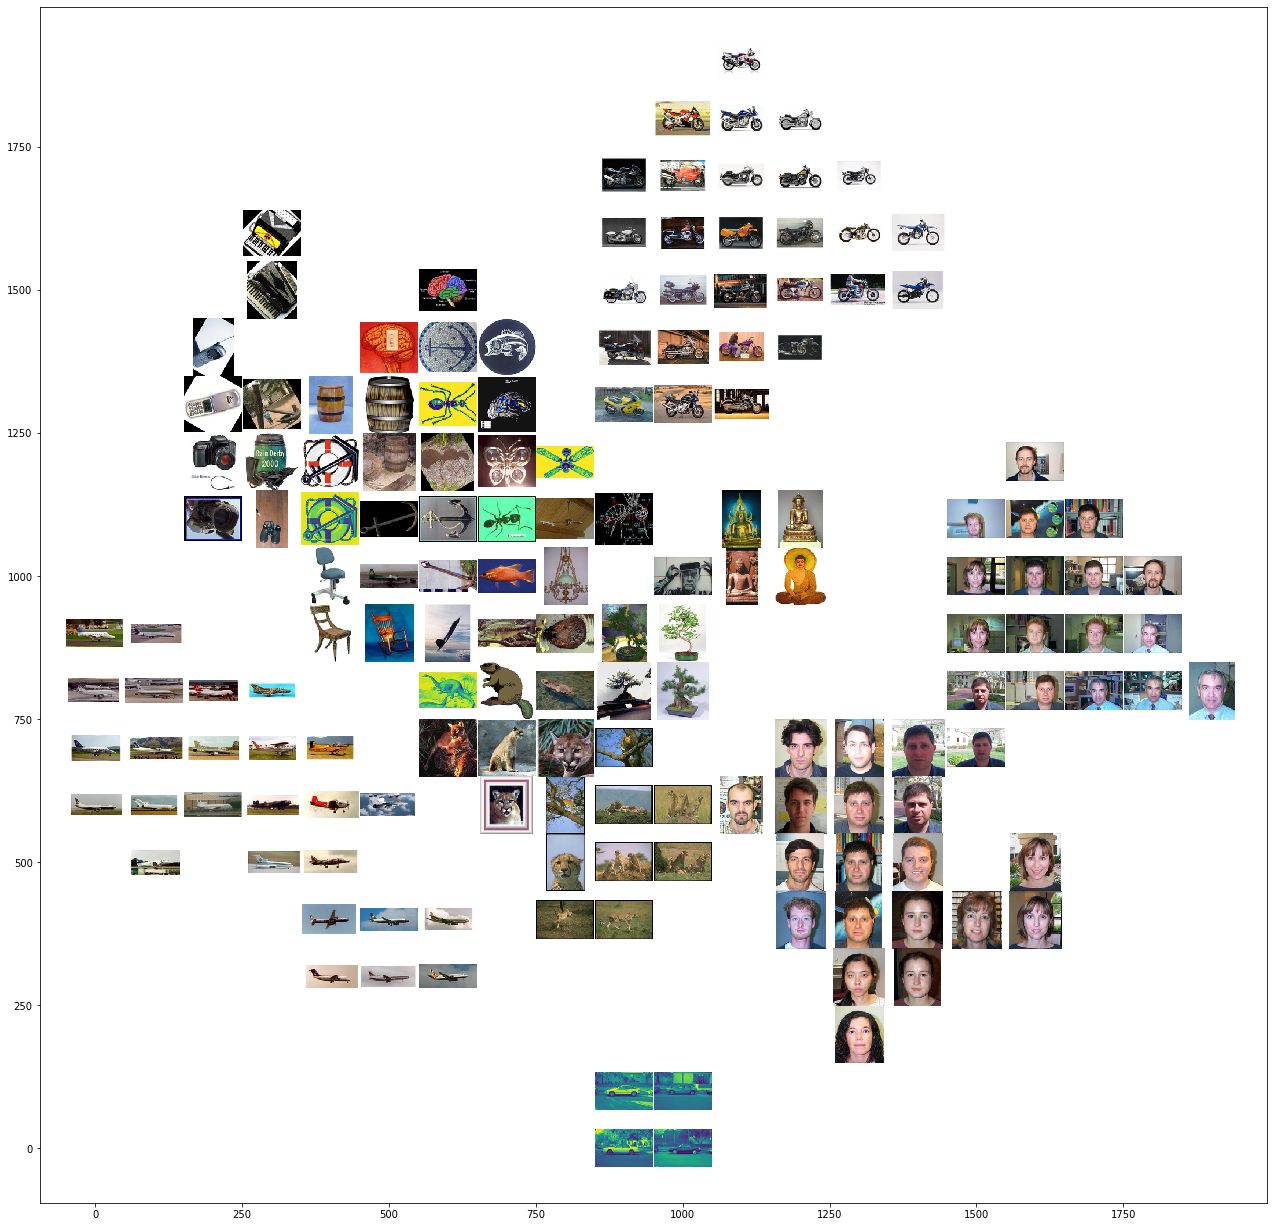

In [0]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)